In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework2

Mounted at /gdrive
/gdrive/My Drive/Homework2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [ ]:
# Building X and y sets: X is made of sequences of length window, and y is the next sequence of length telescope.
# No distinction between different categories here
X = []
y = []
# combinations of (window,telescope,stride) I used: (45,9,8), (40,10,15)
# also a third one with window 48 and telescope 1, per predire faccio 9 predictions, poi append e delete ma non ha funzionato molto meglio, sembra meglio direct forecasting
window = 45    # it was 40
telescope = 9    # it was 10
stride = 8    # it was 15
for i in range(dataset.shape[0]):
  j = periods[i,0]
  while(j+window+telescope < periods[i,1]):    # sfrutto periods per vedere di stare nei limiti
    X.append(dataset[i,j:j+window])
    y.append(dataset[i,j+window:j+window+telescope])
    j = j+stride

In [ ]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((888623, 45), (888623, 9))

In [ ]:
df = pd.DataFrame(dataset).T    # solo per visualizzare
def inspect_dataframe(df, rows):
    figs, axs = plt.subplots(len(rows), 1, sharex=True, figsize=(17,8))
    for i, col in enumerate(rows):
        axs[i].plot(df[col])
        axs[i].set_title(cat[col])
    plt.show()
inspect_dataframe(df, [2000,2004])

In [ ]:
# creating train and test
# qua ho provato vari modi, in questo caso avevo letto la shape e ho deciso di tenere come test le ultime 8623 timeseries estrapolate dai dati
# test_size = 5000
X_train, X_test = np.split(X,[880000])
y_train, y_test = np.split(y,[880000])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(880000, 45) (880000, 9) (8623, 45) (8623, 9)


In [ ]:
for i,element in enumerate(X_train):    # qua aggiungo rumore uniformemente distribuito al training set, l'ho solo scritta ma mai usata perché non so se funzioni
  for j,number in enumerate(element):
    X_train[i,j] = X_train[i,j] + random.random()/100

In [ ]:
X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(880000, 45, 1)

In [ ]:
y_train = np.expand_dims(y_train,axis=2)
y_train.shape

(880000, 9, 1)

In [ ]:
y_test = np.expand_dims(y_test,axis=2)
y_test.shape

(8623, 9, 1)

In [ ]:
X_test = np.expand_dims(X_test,axis=2)
X_test.shape

(8623, 45, 1)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
input_shape,output_shape

((45, 1), (9, 1))

In [ ]:
# piccola modifica rispetto all'originale: qua ho messo due layer LSTM da 32 invece da uno di 64, sperando di diminuire overfitting ma non ha funzionato molto bene, da migliorare

def build_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 32 units, return true very important, I want a sequence
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape: very important because bilstm gives me same sequence length*2, so it gives me 100. But I want 50, so I need to crop, I want a telescope size
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length: I take only cropped last
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 45, 1)]           0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 45, 64)            8704      
 ectional)                                                       
                                                                 
 bidirectional_lstm2 (Bidir  (None, 45, 64)            24832     
 ectional)                                                       
                                                                 
 conv (Conv1D)               (None, 45, 128)           24704     
                                                                 
 output_layer (Conv1D)       (None, 45, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)          

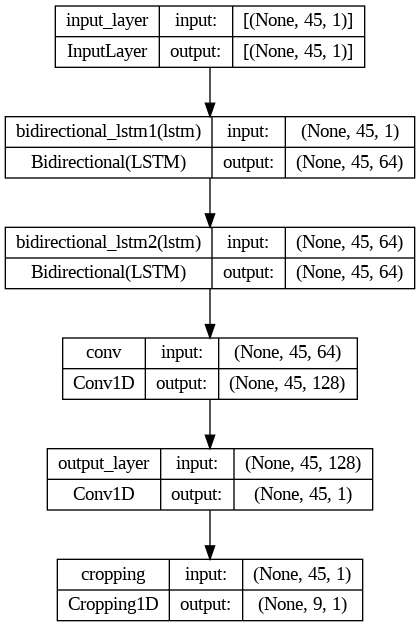

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
12375/12375 [==============================] - 192s 14ms/step - loss: 0.0101 - val_loss: 0.0125 - lr: 0.0010
Epoch 2/200
12375/12375 [==============================] - 172s 14ms/step - loss: 0.0083 - val_loss: 0.0120 - lr: 0.0010
Epoch 3/200
12375/12375 [==============================] - 177s 14ms/step - loss: 0.0078 - val_loss: 0.0115 - lr: 0.0010
Epoch 4/200
12375/12375 [==============================] - 176s 14ms/step - loss: 0.0075 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/200
12375/12375 [==============================] - 179s 14ms/step - loss: 0.0073 - val_loss: 0.0113 - lr: 0.0010
Epoch 6/200
12375/12375 [==============================] - 173s 14ms/step - loss: 0.0072 - val_loss: 0.0113 - lr: 0.0010
Epoch 7/200
12375/12375 [==============================] - 174s 14ms/step - loss: 0.0071 - val_loss: 0.0112 - lr: 0.0010
Epoch 8/200
12375/12375 [==============================] - 173s 14ms/step - loss: 0.0071 - val_loss: 0.0111 - lr: 0.0010
Epoch 9/200
12375/12375 [=======

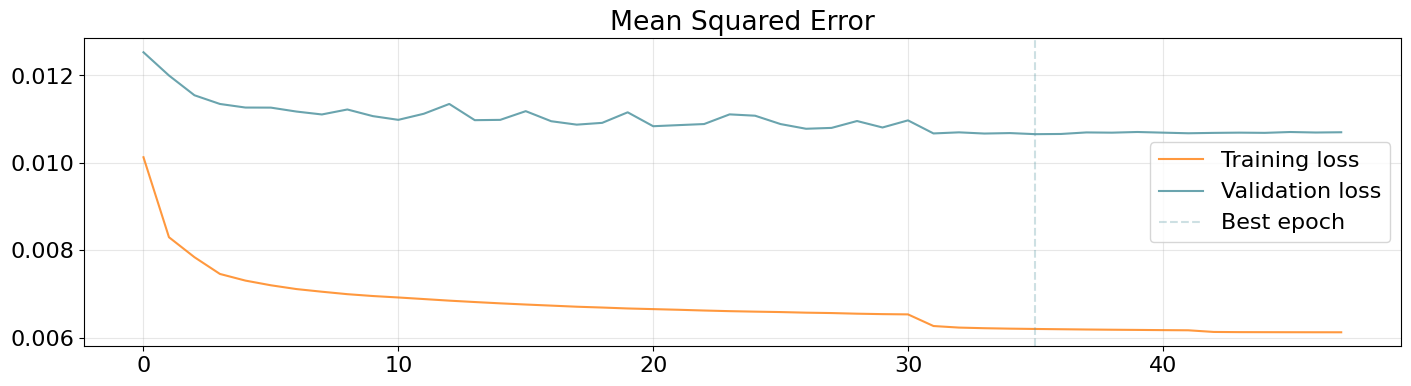

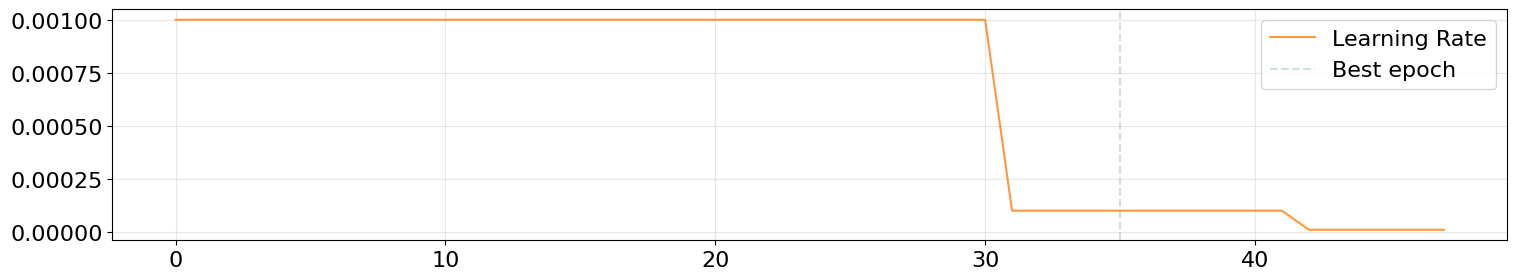

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('SimpleConvLSTM_3')
del model

In [ ]:
model = tfk.models.load_model('SimpleConvLSTM_3')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (8623, 9, 1)
Mean Squared Error: 0.00784633681178093
Mean Absolute Error: 0.054370030760765076


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):    # this shows input, actual labels and predicted labels (what the future he imagines is)
        idx=np.random.randint(0,len(X))

    plt.plot(np.arange(window), X[idx,:])
    plt.plot(np.arange(window,window+telescope), y[idx,:,:], color='orange')
    plt.plot(np.arange(window,window+telescope), pred[idx,:,:], color='green')
    plt.ylim(0,1)
    plt.show()

# funzione modificata dal notebook, forse si può migliorare ma era solo per vedere come funziona

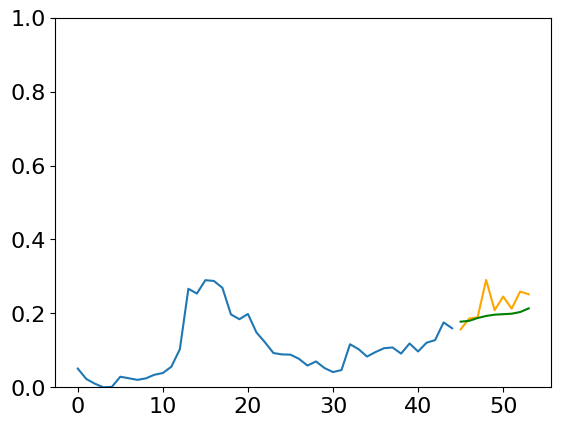

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, telescope=10)

In [ ]:
# da questa cella in poi qualche prova mia per vedere come scrivere il file model.py in modo da ottenere i formati giusti
X.shape

(888623, 45)

In [ ]:
X1 = X[:,-45:]

In [ ]:
X1.shape

(124849, 48)

In [ ]:
X2 = np.expand_dims(X1, axis = 2)

In [ ]:
X2.shape

(124849, 48, 1)

In [ ]:
y2 = model.predict(X2, verbose = 0)

In [ ]:
y2.shape

(124849, 1, 1)

In [ ]:
for w in range(9):    # questo era per autoregressive, ma sembra funzionare meglio il direct
  X3 = np.append(X2,y2,axis=1)
  X3 = np.delete(X3,0,axis=1)
  y3 = model.predict(X3)
  y2 = y3
  X2 = X3

3902/3902 [==============================] - 23s 6ms/step


In [ ]:
X2.shape

(124849, 48, 1)

In [ ]:
X4 = X2[:,-9:,:]

In [ ]:
X5 = np.squeeze(X4, axis=2)

In [ ]:
X5.shape

(124849, 9)

In [ ]:
y2

array([[[0.31549838]],

       [[0.3511283 ]],

       [[0.4156105 ]],

       ...,

       [[0.8434956 ]],

       [[0.49102816]],

       [[0.59935224]]], dtype=float32)

In [ ]:
X_test[,:,].append(y2)

SyntaxError: ignored

In [ ]:
X_test.shape

(5000, 48, 1)

In [ ]:
y2.shape

(5000, 1, 1)

In [ ]:
X_test1 = np.append(X_test,y2,axis=1)

In [ ]:
X_test1.shape

(5000, 49, 1)

In [ ]:
y1 =